# Reuters Newswire Classification
*Charles Roberts, Kyle Rohde, Noah Trilling*

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

seed = 42
max_sequence_length = 300
vocabulary_size = 2000

## Exploratory Data Analysis
Load the newswire dataset, word index, and label names.

In [4]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(test_split=0, seed=seed)
index_by_word = reuters.get_word_index(path="reuters_word_index.json")
word_by_offset_index = {index + 3: word for word, index in index_by_word.items()}
reuters_label_names = reuters.get_label_names()
label_names = [str(i) for i in range(46)]  # 46 total classes
y_full_label_names_decoded = [reuters_label_names[label] for label in y_full]
num_classes = len(label_names)
print(f"Total samples: {len(x_full)}")
print(f"Total classes: {num_classes}")
print(f"Total vocabulary: {len(index_by_word)}")
print(f"Longest Sequence: {max([len(x) for x in x_full])}")
print(f"Shortest Sequence: {min([len(x) for x in x_full])}")
print(f"Average Sequence Length: {np.mean([len(x) for x in x_full])}")
sorted_word_index = sorted(index_by_word.items(), key=lambda x: x[1])
print(f"Top 50 Words: {sorted_word_index[:50]}")
print(f"Bottom 50 Words: {sorted_word_index[-50:]}")
print(f"All Classes: {reuters_label_names}")
print(f"Sample x: {x_full[0]}")
print(f"Sample y: {y_full[0]}")
print(f"Sample x (decoded): {[word_by_offset_index.get(i, '?') for i in x_full[0]]}")
print(f"Sample y (decoded): {reuters_label_names[y_full[0]]}")

Total samples: 11228
Total classes: 46
Total vocabulary: 30979
Longest Sequence: 2376
Shortest Sequence: 2
Average Sequence Length: 145.96419665122906
Top 50 Words: [('the', 1), ('of', 2), ('to', 3), ('in', 4), ('said', 5), ('and', 6), ('a', 7), ('mln', 8), ('3', 9), ('for', 10), ('vs', 11), ('dlrs', 12), ('it', 13), ('reuter', 14), ('000', 15), ('1', 16), ('pct', 17), ('on', 18), ('from', 19), ('is', 20), ('that', 21), ('its', 22), ('cts', 23), ('by', 24), ('at', 25), ('year', 26), ('be', 27), ('with', 28), ('2', 29), ('will', 30), ('was', 31), ('billion', 32), ('he', 33), ('u', 34), ('s', 35), ('net', 36), ('has', 37), ('would', 38), ('an', 39), ('as', 40), ('5', 41), ('not', 42), ('loss', 43), ('4', 44), ('1986', 45), ('company', 46), ('which', 47), ('but', 48), ('this', 49), ('shr', 50)]
Bottom 50 Words: [('teishoku', 30930), ('bbd', 30931), ('grandmarais', 30932), ('enahnce', 30933), ('jerritt', 30934), ('wilq', 30935), ('cogeca', 30936), ('unflappable', 30937), ('cogeco', 30938),

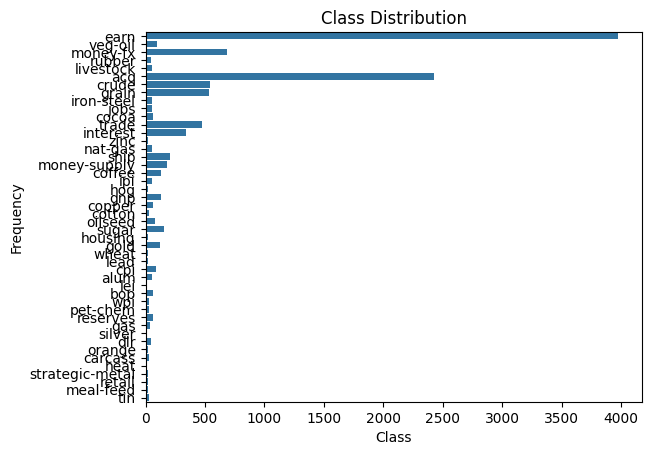

In [5]:
sns.countplot(y_full_label_names_decoded)
plt.title("Class Distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.show()

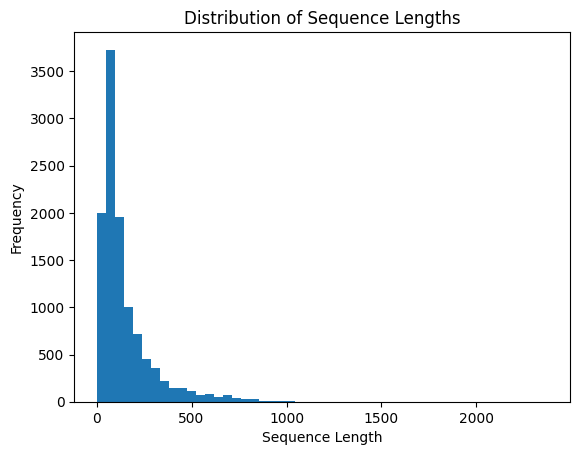

In [6]:
sequence_lengths = [len(seq) for seq in x_full]
plt.hist(sequence_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

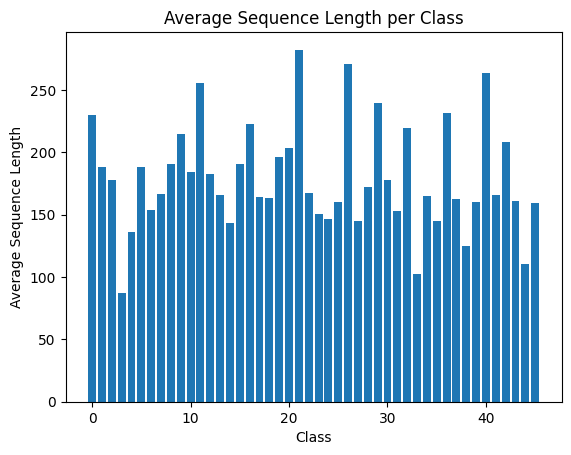

In [7]:
import numpy as np

avg_lengths_per_class = [np.mean([len(x_full[i]) for i in range(len(y_full)) if y_full[i] == label]) for label in range(len(label_names))]
plt.bar(range(len(label_names)), avg_lengths_per_class)
plt.title("Average Sequence Length per Class")
plt.xlabel("Class")
plt.ylabel("Average Sequence Length")
plt.show()

## Data Preprocessing

In [8]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(num_words=vocabulary_size, skip_top=50, maxlen=max_sequence_length, test_split=0, seed=seed)
x_full = [[token for token in sequence if token not in {0, 1, 2}] for sequence in x_full]
x_train, x_temp, y_train, y_temp = train_test_split(
    x_full, y_full, test_size=0.2, random_state=seed
)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=seed
)
x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding="post")
x_val_padded = pad_sequences(x_val, maxlen=max_sequence_length, padding="post")
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding="post")

## Classical Machine Learning

In [9]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_padded, y_train)

y_val_pred = clf.predict(x_val_padded)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

y_test_pred = clf.predict(x_test_padded)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00         7
           3       0.57      0.67      0.62       400
           4       0.22      0.32      0.26       189
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        22
          11       0.09      0.03      0.05        32
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00        48

c:\Users\NoahMSOE\Documents\GitHub\csc-6621-final-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NoahMSOE\Documents\GitHub\csc-6621-final-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NoahMSOE\Documents\GitHub\csc-6621-final-project\.venv\Lib\site-packages\sklear

## Deep Learning

In [10]:
model = Sequential(
    [
        Embedding(
            input_dim=vocabulary_size, output_dim=64, input_length=max_sequence_length
        ),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation="relu"),
        Dense(
            num_classes, activation="softmax"
        )
    ]
)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(
    x_train_padded,
    y_train,
    validation_data=(x_val_padded, y_val),
    epochs=5,
    batch_size=64,
)

c:\Users\NoahMSOE\Documents\GitHub\csc-6621-final-project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.4312 - loss: 2.6238 - val_accuracy: 0.6309 - val_loss: 1.5315
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.6652 - loss: 1.3999 - val_accuracy: 0.6640 - val_loss: 1.3688
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.7047 - loss: 1.2145 - val_accuracy: 0.7011 - val_loss: 1.2169
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.7483 - loss: 1.0417 - val_accuracy: 0.7342 - val_loss: 1.1334
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.7848 - loss: 0.8955 - val_accuracy: 0.7553 - val_loss: 1.0641


In [11]:

test_loss, test_accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7520 - loss: 1.0748
Test Accuracy: 0.74


## Transfer Learning (Stretch Goal)

In [ ]:
glove_zip = "glove.6B.zip"
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

if not os.path.exists("glove.6B.100d.txt"):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip)

    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")


In [ ]:
embeddings_index = {}
embedding_dim = 100
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in index_by_word.items():
    if i < vocabulary_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



model = Sequential(
    [
        Embedding(
            input_dim=vocabulary_size,  # Vocabulary size (num_words from word_index)
            output_dim=embedding_dim,  # GloVe embedding dimensionality (100)
            weights=[embedding_matrix],  # Use the pre-trained GloVe embeddings
            input_length=x_train_padded.shape[
                1
            ],  # Length of input sequences (padded sequences length)
            trainable=True,  # Freeze the embeddings (set True to allow fine-tuning)
        ),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

history = model.fit(
    x_train_padded,
    y_train,
    validation_data=(x_val_padded, y_val),
    epochs=5,
    batch_size=64,
)

c:\Users\NoahMSOE\Documents\GitHub\csc-6621-final-project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,000 (781.25 KB)

 Trainable params: 200,000 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.4283 - loss: 2.4862 - val_accuracy: 0.5968 - val_loss: 1.6132
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.6355 - loss: 1.5076 - val_accuracy: 0.6650 - val_loss: 1.3883
Epoch 3/5
105/125 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7126 - loss: 1.1869

## Pretrained Model Fine-Tuning (Stretch Goal)